## Code pour le devoir de la Mécanique de la Fracture

In [1]:
import sys
sys.path.append("../utils_9_11")

# Import required libraries
import matplotlib.pyplot as plt
import numpy as np

import dolfinx.fem as fem
import dolfinx.mesh as mesh
import dolfinx.io as io
import dolfinx.plot as plot
import dolfinx.fem.petsc
import ufl

from mpi4py import MPI
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType


plt.rcParams["figure.figsize"] = (6,3)

outdir = "output"
from pathlib import Path
Path(outdir).mkdir(parents=True, exist_ok=True)

[DESKTOP-GVI2CPO:01644] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.DESKTOP-GVI2CPO.1000/jf.0/2556887040/shared_mem_cuda_pool.DESKTOP-GVI2CPO could be created.
[DESKTOP-GVI2CPO:01644] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


On calcule le facteur d'intensite de contrainte de manière adimensionnel avec $E = 1$, le deplacement imposé $\delta L =1$ et la dimmension $L_x = 1$

In [2]:
from elastic_solver import solve_elasticity_devoir

# nu=0.4
# E=3000e6
# Lx=10/100
# Ly=45/2/100
# Lcrack=10/1000
# lc=0.009
# refinement_ratio=10
# dist_min=0.03
# dist_max=0.05
# verbosity=10
# delta_L = 500*1e-6

nu=0.4
E=3000e6
E=E/E
load=0
Lx=10/100
Ly=45/2/100/Lx
Lcrack=10/1000/Lx
lc=0.009/Lx
refinement_ratio=10
dist_min=0.03/Lx
dist_max=0.05/Lx
verbosity=10
delta_L = 700*1e-6
delta_L = delta_L/delta_L

uh, energy, sigma_ufl = solve_elasticity_devoir(
nu=nu,
E=E,
load=0,
Lx=Lx/Lx,
Ly=Ly,
Lcrack=Lcrack,
lc=lc,
refinement_ratio=refinement_ratio,
dist_min=dist_min,
dist_max=dist_max,
verbosity=verbosity,
delta_L = delta_L
)

ModuleNotFoundError: No module named 'elastic_solver'

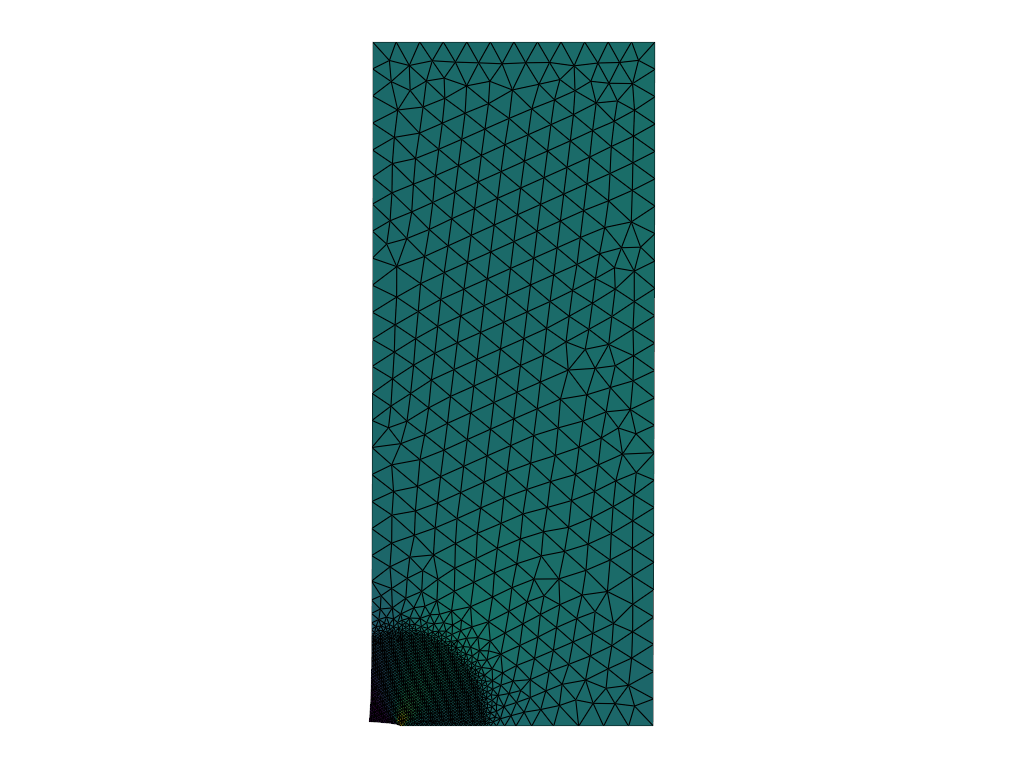

In [ ]:
from plots import warp_plot_2d
import pyvista
pyvista.set_jupyter_backend("static")
pyvista.start_xvfb()

import ufl
sigma_iso = 1./3*ufl.tr(sigma_ufl)*ufl.Identity(len(uh))
sigma_dev =  sigma_ufl - sigma_iso
von_Mises = ufl.sqrt(3./2*ufl.inner(sigma_dev, sigma_dev))
V_dg = fem.functionspace(uh.function_space.mesh, ("DG", 0))
stress_expr = fem.Expression(von_Mises, V_dg.element.interpolation_points())
vm_stress = fem.Function(V_dg)
vm_stress.interpolate(stress_expr)

plotter = warp_plot_2d(uh,cell_field=vm_stress,field_name="Von Mises stress", factor=.1,show_edges=True,clim=[0.0, 1.0],show_scalar_bar=False)
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot(f"{outdir}/VonMises.png")

## Crack opening displacement (COD)

Let us get the vertical displacement at the crack lip

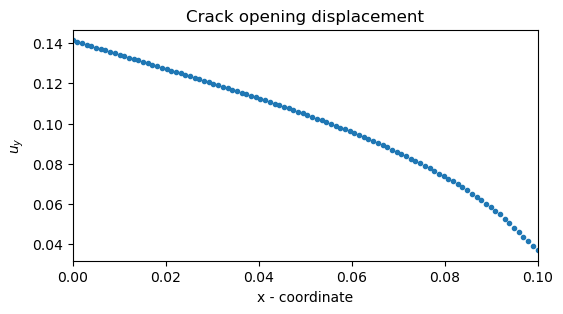

In [ ]:
from evaluate_at_points import evaluate_at_points
xs = np.linspace(0,Lcrack,100)
ys = 0.0 * np.ones_like(xs)
zs = 0.0 * np.ones_like(xs)
points = np.array([xs,ys,zs])
u_values = evaluate_at_points(points,uh)
us = u_values[:,1]
plt.plot(xs,us,".")
plt.xlim([0.,Lcrack])
plt.xlabel("x - coordinate")
plt.ylabel(r"$u_y$")
plt.title("Crack opening displacement")
plt.savefig(f"{outdir}/COD.png")

K approximated to  0.2801281592032512


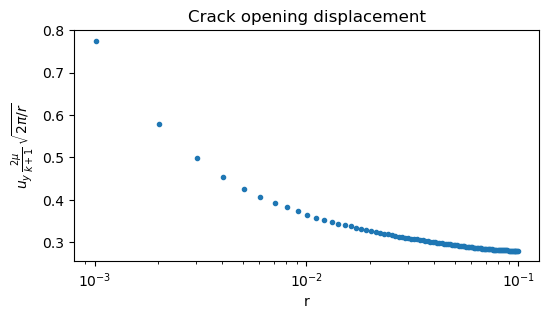

In [ ]:
r = (Lcrack-xs)
#r_ = r[np.where(xs<Lcrack)]
#us_ = us[np.where(xs<Lcrack)]

mu = E / (2.0 * (1.0 + nu))
kappa = (3 - nu) / (1 + nu)
factor = 2 * mu / (kappa + 1)

plt.semilogx(r,us * np.sqrt(2*np.pi/r)*factor,".")
plt.xlabel("r")
plt.ylabel(r"${u_y} \,\frac{2\mu}{k+1} \,\sqrt{2\pi/r}$")
plt.title("Crack opening displacement")
plt.savefig(f"{outdir}/KI-COD.png")

K = us * np.sqrt(2*np.pi/r)*factor
print('K approximated to ', K[0])

La K obtenue est égale à 0.28

## Stress at the crack tip

Let us get the stress around the crack tip

In [ ]:
xs = np.linspace(Lcrack,2*Lcrack,1000)
ys = 0.0 * np.ones_like(xs)
zs = 0.0 * np.ones_like(xs)
points = np.array([xs,ys,zs])
r = (xs-Lcrack)
sigma_xx_expr = fem.Expression(sigma_ufl[0,0], V_dg.element.interpolation_points())
sigma_xx = fem.Function(V_dg)
sigma_xx.interpolate(sigma_xx_expr)
sigma_xx_values = evaluate_at_points(points,sigma_xx)

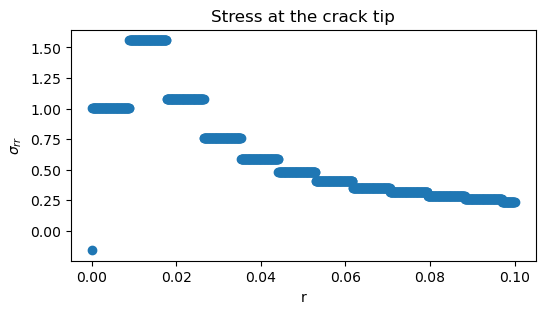

In [ ]:
plt.plot(r,sigma_xx_values[:,0],"o")
plt.xlabel("r")
plt.ylabel(r"$\sigma_{rr}$")
plt.title("Stress at the crack tip")
plt.savefig(f"{outdir}/stress.png")

As detailed in the lectures notes, we can estimate the value of the stress intensity factor $K_I$ by extrapolating $\sigma_{rr} \sqrt{2\pi r}$

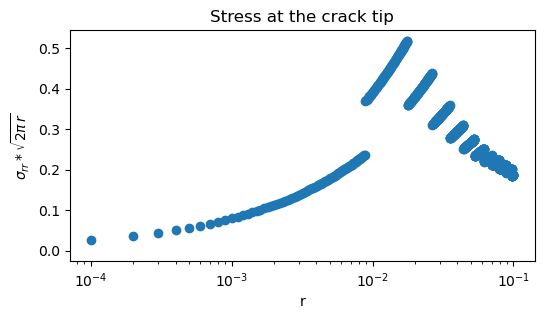

In [ ]:
plt.semilogx(r,sigma_xx_values[:,0]*np.sqrt(2*np.pi*r),"o")
plt.xlabel("r")
plt.ylabel(r"$\sigma_{rr}*\sqrt{2\pi\,r}$")
plt.title("Stress at the crack tip")
plt.savefig(f"{outdir}/KI-stress.png")

From Irwin's formula in plane-stress, we get the energy release rate (ERR)

In [ ]:
KI_estimate = 0.28
G_estimate = KI_estimate ** 2 / E # Irwin's formula in plane stress
print(f"ERR estimate is {G_estimate}")

ERR estimate is 0.07840000000000001


# The elastic energy release rate 

Let us first calculate the potential energy for several crack lengths. We multiply the result by `2`` to account for the symmetry when comparing with the $K_I$ estimate above.

In [ ]:
Ls = np.linspace(Lcrack,Lcrack*2.4,10)
print(Ls)
energies = np.zeros_like(Ls)
Gs = np.zeros_like(Ls)
for (i, L) in enumerate(Ls):
    # delta_L = (-21*L*1000+920)*1e-6
    # print(delta_L, L)
    uh, energies[i], _ = solve_elasticity_devoir(nu=nu,
                                                E=E,
                                                load=0,
                                                Lx=1,
                                                Ly=Ly,
                                                Lcrack=L,
                                                lc=0.01,
                                                refinement_ratio=refinement_ratio,
                                                dist_min=dist_min,
                                                dist_max=dist_max,
                                                verbosity=verbosity,
                                                delta_L = delta_L)
    
energies = energies *2

[0.1        0.11555556 0.13111111 0.14666667 0.16222222 0.17777778
 0.19333333 0.20888889 0.22444444 0.24      ]
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 70%] Meshing curve 4 (Line)
Info    : [ 90%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.0040422s, CPU 0.003933s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.302979s, CPU 0.303586s)
Info    : 10108 nodes 20219 elements
The potential energy for Lcrack=1.000e-01 is 2.620e-01
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 70%] Meshing curve 4 (Line)
Info    : [ 90%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.0039086s, CPU 0.00382s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done m

In [ ]:
print(energies)

[0.52404197 0.5223436  0.52037178 0.5181232  0.51559069 0.51275371
 0.50961196 0.50616755 0.50238339 0.49827648]


Value of energy for crack 0.1 = 0.10918118924109683


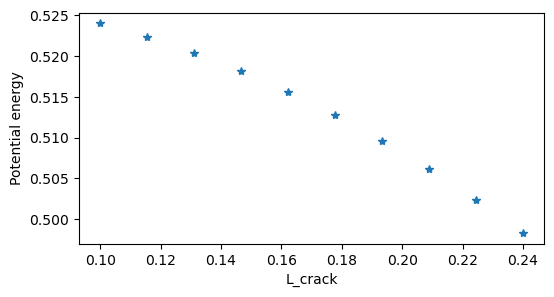

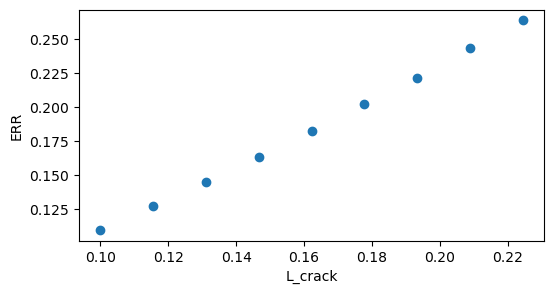

In [ ]:
ERR_naif = -np.diff(energies)/np.diff(Ls)

plt.figure()
plt.plot(Ls, energies,"*")
plt.xlabel("L_crack")
plt.ylabel("Potential energy")
plt.figure()
plt.plot(Ls[0:-1], ERR_naif,"o")
plt.ylabel("ERR")
plt.xlabel("L_crack")
# plt.axhline(G_estimate,linestyle='--',color="gray")
# plt.axvline(Lcrack,linestyle='--',color="gray") 

print(f"Value of energy for crack 0.1 = {ERR_naif[0]}")

In [ ]:
G_estimate = 0.109
K_estimate = (G_estimate*E)**(1/2) # Irwin's formula in plane stress
print(f"K estimate is {K_estimate}")

K estimate is 0.3301514803843836


# G-theta method: domain derivative

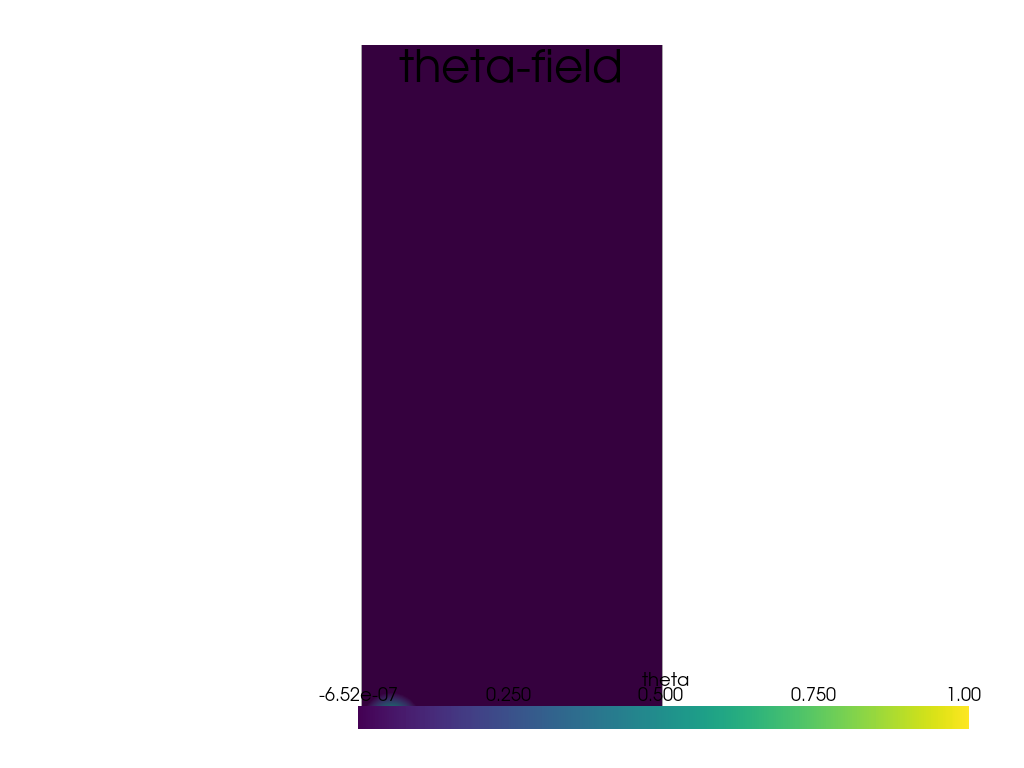

In [ ]:
def create_theta_field(domain,crack_tip,R_int,R_ext):
    
    def tip_distance(x):
          return np.sqrt((x[0]-crack_tip[0])**2 + (x[1]-crack_tip[1])**2) 
    
    V_theta = fem.functionspace(domain,("Lagrange",1))
    
   
    # Define variational problem to define the theta-field. 
    # We solve a simple laplacian
    theta, theta_ = ufl.TrialFunction(V_theta), ufl.TestFunction(V_theta)
    a = ufl.dot(ufl.grad(theta), ufl.grad(theta_)) * ufl.dx
    L = fem.Constant(domain,ScalarType(0.)) * theta_ * ufl.dx(domain=domain) 

    # Set the BCs
    # Imposing 1 in the inner circle and zero in the outer circle
    dofs_inner = fem.locate_dofs_geometrical(V_theta,lambda x : tip_distance(x) < R_int)
    dofs_out = fem.locate_dofs_geometrical(V_theta,lambda x : tip_distance(x) > R_ext)
    bc_inner = fem.dirichletbc(ScalarType(1.),dofs_inner,V_theta)
    bc_out = fem.dirichletbc(ScalarType(0.),dofs_out,V_theta)
    bcs = [bc_out, bc_inner]

    # solve the problem
    problem = fem.petsc.LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "gmres", "pc_type": "gamg"})
    thetah = problem.solve()
    return thetah

crack_tip = np.array([Lcrack,0])
crack_tangent = np.array([1,0])
crack_tip = np.array([Lcrack,0])
R_int = Lcrack/4.
R_ext = Lcrack
domain = uh.function_space.mesh
thetah = create_theta_field(domain,crack_tip,R_int,R_ext)


# Plot theta
topology, cell_types, geometry = plot.vtk_mesh(thetah.function_space)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
grid.point_data["theta"] = thetah.x.array.real
grid.set_active_scalars("theta")
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=False)
plotter.add_title("theta-field")
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()

Hence, we can compute the ERR with the formula
$$
G  = \int_\Omega \left(\sigma(\varepsilon(u))\cdot(\nabla u\nabla\theta)-\dfrac{1}{2}\sigma(\varepsilon(u))\cdot \varepsilon(u) \mathrm{div}(\theta)\,\right)\mathrm{dx}$$

In [ ]:
Lcrack


0.09999999999999999

In [ ]:

crack_tip = np.array([Lcrack,0])
crack_tangent = np.array([1,0])
R_int = Lcrack/4
R_ext = Lcrack
uh, energy, sigma_ufl = solve_elasticity_devoir(nu=nu,
E=E,
load=0,
Lx=Lx/Lx,
Ly=Ly,
Lcrack=Lcrack,
lc=lc,
refinement_ratio=refinement_ratio,
dist_min=dist_min,
dist_max=dist_max,
verbosity=verbosity,
delta_L = delta_L)

thetah = create_theta_field(uh.function_space.mesh,crack_tip,R_int,R_ext)
eps_ufl = ufl.sym(ufl.grad(uh))
theta_vector = ufl.as_vector([1.,0.]) * thetah
dx = ufl.dx(domain=uh.function_space.mesh)
first_term = ufl.inner(sigma_ufl,ufl.grad(uh) * ufl.grad(theta_vector)) * dx
second_term = - 0.5 * ufl.inner(sigma_ufl,eps_ufl) * ufl.div(theta_vector) * dx

G_theta = 2 * fem.assemble_scalar(fem.form(first_term + second_term))
print(f'The ERR computed with the G-theta method is {G_theta:2.4f}' )

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 70%] Meshing curve 4 (Line)
Info    : [ 90%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.0035047s, CPU 0.004255s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0510661s, CPU 0.051808s)
Info    : 2079 nodes 4161 elements
The potential energy for Lcrack=1.000e-01 is 2.619e-01
The ERR computed with the G-theta method is 0.1044


In [ ]:
G_estimate = 0.1044
K_estimate = (G_estimate*E)**(1/2) # Irwin's formula in plane stress
print(f"K estimate is {K_estimate}")

K estimate is 0.32310988842807026


Prueba adimimensional


In [ ]:
from elastic_solver import solve_elasticity_devoir

nu=0.4
E=3000e6
E=E/E
load=0
Lx=10/100
Ly=45/2/100/Lx
Lcrack=10/1000/Lx
lc=0.009/Lx
refinement_ratio=10
dist_min=0.03/Lx
dist_max=0.05/Lx
verbosity=10
delta_L = 700*1e-6
delta_L = delta_L/delta_L

uh, energy, sigma_ufl = solve_elasticity_devoir(
nu=nu,
E=1,
load=0,
Lx=1,
Ly=Ly,
Lcrack=Lcrack,
lc=lc,
refinement_ratio=refinement_ratio,
dist_min=dist_min,
dist_max=dist_max,
verbosity=verbosity,
delta_L = 1
)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 70%] Meshing curve 4 (Line)
Info    : [ 90%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.0031563s, CPU 0.003457s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 0.0553887s, CPU 0.056033s)
Info    : 2079 nodes 4161 elements
The potential energy for Lcrack=1.000e-01 is 2.619e-01


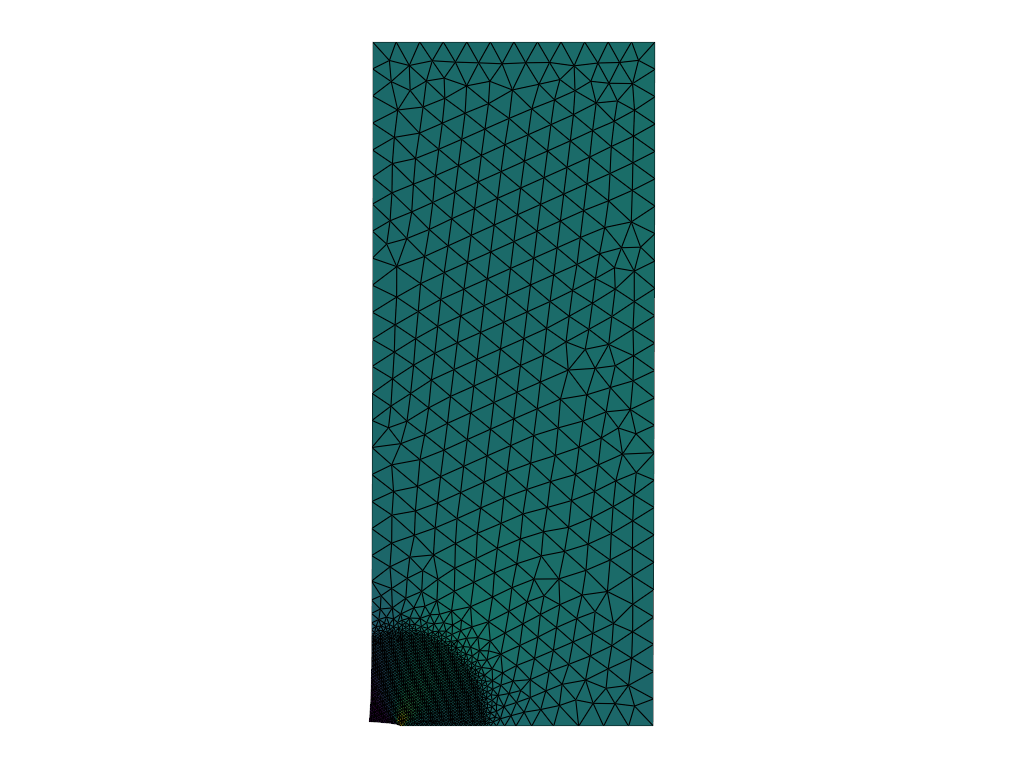

In [ ]:
from plots import warp_plot_2d
import pyvista
pyvista.set_jupyter_backend("static")
pyvista.start_xvfb()

import ufl
sigma_iso = 1./3*ufl.tr(sigma_ufl)*ufl.Identity(len(uh))
sigma_dev =  sigma_ufl - sigma_iso
von_Mises = ufl.sqrt(3./2*ufl.inner(sigma_dev, sigma_dev))
V_dg = fem.functionspace(uh.function_space.mesh, ("DG", 0))
stress_expr = fem.Expression(von_Mises, V_dg.element.interpolation_points())
vm_stress = fem.Function(V_dg)
vm_stress.interpolate(stress_expr)

plotter = warp_plot_2d(uh,cell_field=vm_stress,field_name="Von Mises stress", factor=.1,show_edges=True,clim=[0.0, 1.0],show_scalar_bar=False)
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot(f"{outdir}/VonMises.png")

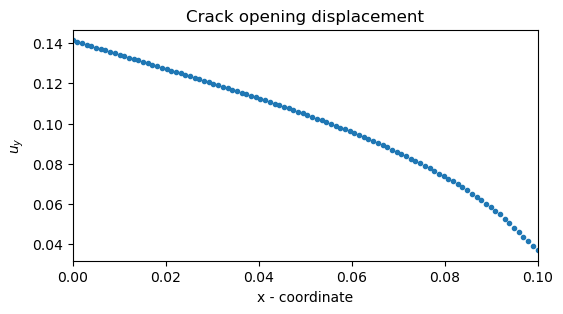

In [ ]:
from evaluate_at_points import evaluate_at_points
xs = np.linspace(0,Lcrack,100)
ys = 0.0 * np.ones_like(xs)
zs = 0.0 * np.ones_like(xs)
points = np.array([xs,ys,zs])
u_values = evaluate_at_points(points,uh)
us = u_values[:,1]
plt.plot(xs,us,".")
plt.xlim([0.,Lcrack])
plt.xlabel("x - coordinate")
plt.ylabel(r"$u_y$")
plt.title("Crack opening displacement")
plt.savefig(f"{outdir}/COD.png")

K approximated to  0.2801281592032512


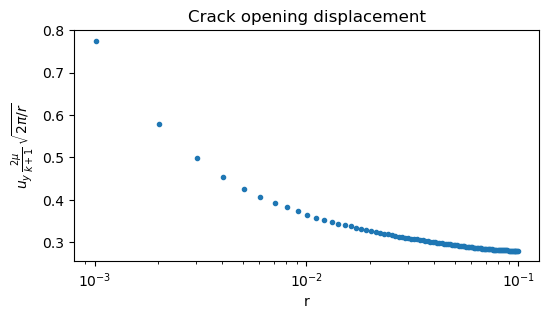

In [ ]:
r = (Lcrack-xs)
#r_ = r[np.where(xs<Lcrack)]
#us_ = us[np.where(xs<Lcrack)]

mu = E / (2.0 * (1.0 + nu))
kappa = (3 - nu) / (1 + nu)
factor = 2 * mu / (kappa + 1)

plt.semilogx(r,us * np.sqrt(2*np.pi/r)*factor,".")
plt.xlabel("r")
plt.ylabel(r"${u_y} \,\frac{2\mu}{k+1} \,\sqrt{2\pi/r}$")
plt.title("Crack opening displacement")
plt.savefig(f"{outdir}/KI-COD.png")

K = us * np.sqrt(2*np.pi/r)*factor
print('K approximated to ', K[0])

## 5. Determine numerically with one of the methods above, $K(a/l)$ for several values of a/l in the range corresponding to a in [5; 30]

[0.05 0.1  0.15 0.2  0.25 0.3 ]
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 70%] Meshing curve 4 (Line)
Info    : [ 90%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.0043529s, CPU 0.004378s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.248506s, CPU 0.250098s)
Info    : 8668 nodes 17339 elements
The potential energy for Lcrack=5.000e-02 is 2.639e-01


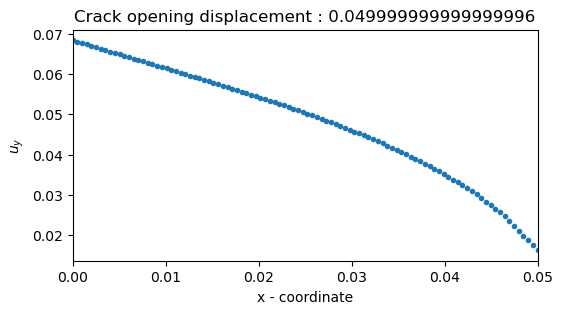

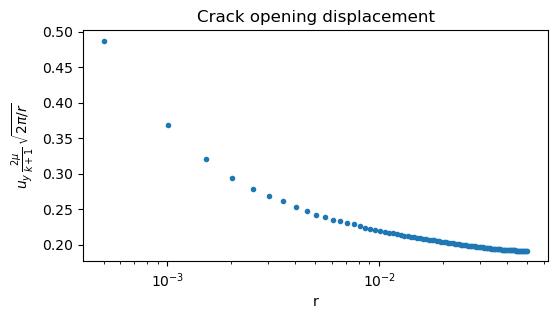

K approximated to  0.19161236946971577
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 70%] Meshing curve 4 (Line)
Info    : [ 90%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.0043781s, CPU 0.004309s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.281892s, CPU 0.282986s)
Info    : 9999 nodes 20001 elements
The potential energy for Lcrack=1.000e-01 is 2.620e-01


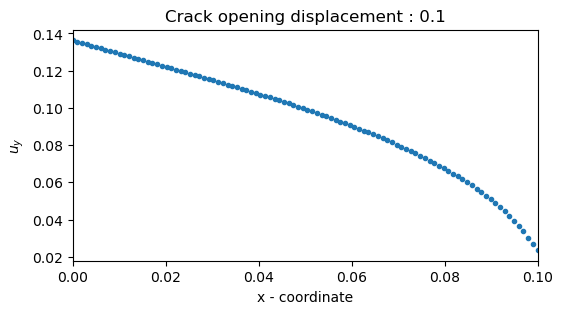

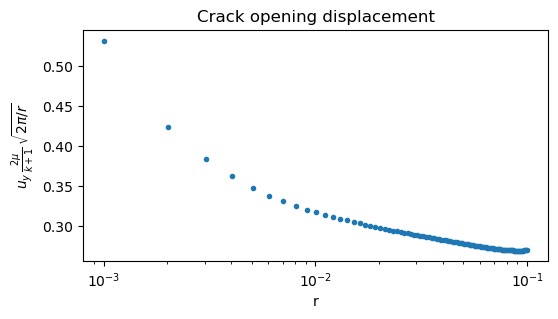

K approximated to  0.27019201959724953
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 70%] Meshing curve 4 (Line)
Info    : [ 90%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.0043356s, CPU 0.004271s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.367117s, CPU 0.368496s)
Info    : 11350 nodes 22703 elements
The potential energy for Lcrack=1.500e-01 is 2.588e-01


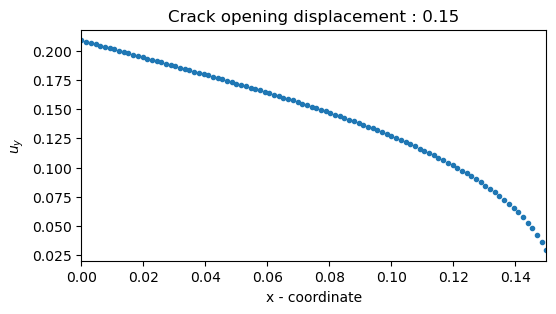

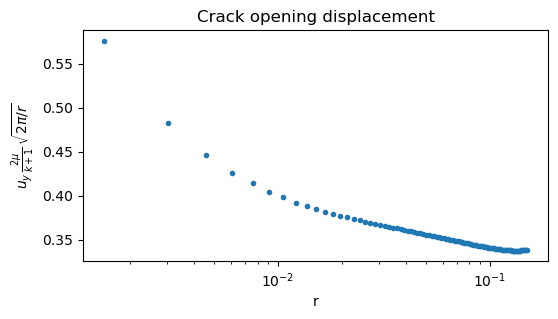

K approximated to  0.3383435497832366
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 70%] Meshing curve 4 (Line)
Info    : [ 90%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.0043859s, CPU 0.004376s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.387699s, CPU 0.370043s)
Info    : 12438 nodes 24879 elements
The potential energy for Lcrack=2.000e-01 is 2.542e-01


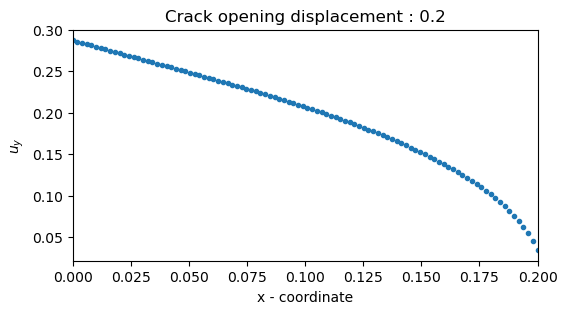

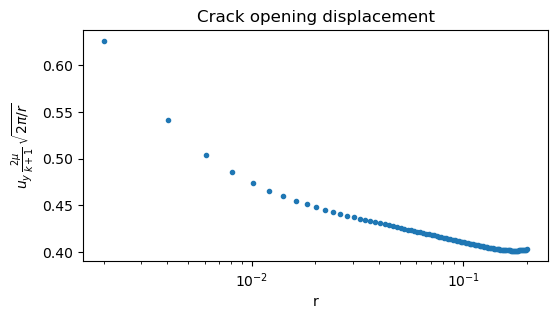

K approximated to  0.40291538770816326
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 70%] Meshing curve 4 (Line)
Info    : [ 90%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.0056959s, CPU 0.005999s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.58363s, CPU 0.585532s)
Info    : 13358 nodes 26719 elements
The potential energy for Lcrack=2.500e-01 is 2.478e-01


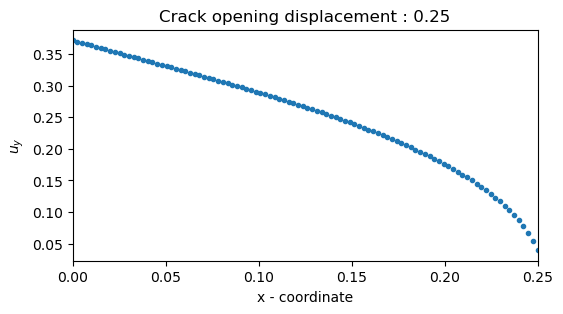

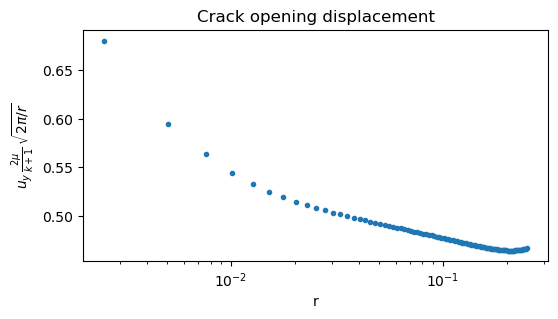

K approximated to  0.4666042086973331
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 70%] Meshing curve 4 (Line)
Info    : [ 90%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.00557251s, CPU 0.00588s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.500897s, CPU 0.502478s)
Info    : 13968 nodes 27939 elements
The potential energy for Lcrack=3.000e-01 is 2.398e-01


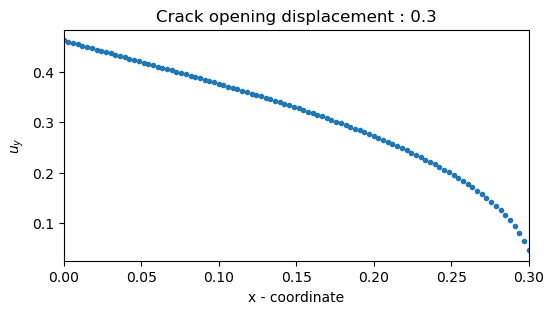

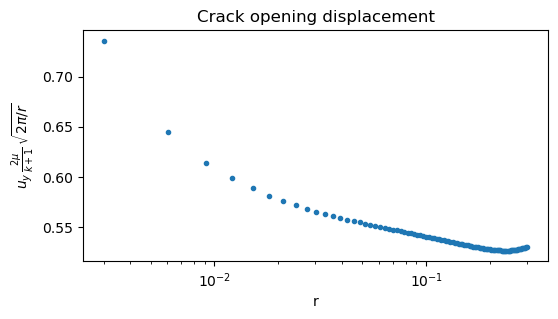

K approximated to  0.5303887146091669


In [ ]:
from evaluate_at_points import evaluate_at_points
Lcrack = 5/1000
Ls = np.linspace(Lcrack/Lx,Lcrack*6/Lx,6)
print(Ls)
energies = np.zeros_like(Ls)
Gs = np.zeros_like(Ls)
K = np.zeros_like(Ls)
for (i, L) in enumerate(Ls):
    # delta_L = (-21*L*1000+920)*1e-6
    # print(delta_L, L)
    uh, energies[i], _ = solve_elasticity_devoir(nu=nu,
                                                E=E,
                                                load=0,
                                                Lx=1,
                                                Ly=Ly,
                                                Lcrack=L,
                                                lc=0.02,
                                                refinement_ratio=20,
                                                dist_min=dist_min,
                                                dist_max=dist_max,
                                                verbosity=verbosity,
                                                delta_L = 1)
    
    xs = np.linspace(0,L,100)
    ys = 0.0 * np.ones_like(xs)
    zs = 0.0 * np.ones_like(xs)
    points = np.array([xs,ys,zs])
    u_values = evaluate_at_points(points,uh)
    us = u_values[:,1]
    plt.figure()
    plt.plot(xs,us,".")
    plt.xlim([0.,L])
    plt.xlabel("x - coordinate")
    plt.ylabel(r"$u_y$")
    plt.title(f"Crack opening displacement : {L}")
    plt.show()
    # plt.savefig(f"{outdir}/COD.png")

    r = (L-xs)
    #r_ = r[np.where(xs<Lcrack)]
    #us_ = us[np.where(xs<Lcrack)]

    mu = E / (2.0 * (1.0 + nu))
    kappa = (3 - nu) / (1 + nu)
    factor = 2 * mu / (kappa + 1)
    plt.figure()
    plt.semilogx(r,us * np.sqrt(2*np.pi/r)*factor,".")
    plt.xlabel("r")
    plt.ylabel(r"${u_y} \,\frac{2\mu}{k+1} \,\sqrt{2\pi/r}$")
    plt.title("Crack opening displacement")
    # plt.savefig(f"{outdir}/KI-COD.png")
    plt.show()

    k = us * np.sqrt(2*np.pi/r)*factor
    K[i] = k[0]
    print('K approximated to ', k[0])
    

[0.19161237 0.27019202 0.33834355 0.40291539 0.46660421 0.53038871]


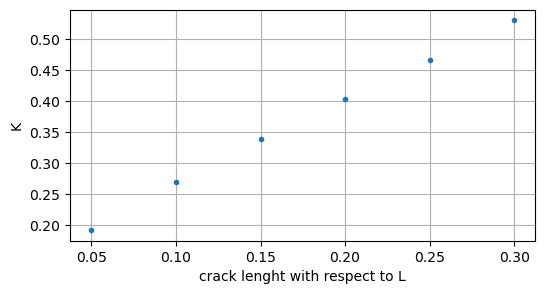

In [24]:
print(K)

plt.figure()
plt.plot(Ls,K,".")
plt.xlabel("crack lenght with respect to L")
plt.ylabel("K")
plt.grid()


## 6. Calcul de R(l)

In [25]:
nu=0.4
E=3000e6
E=E/E
load=0
Lx=10/100
Ly=45/2/100/Lx
Lcrack=5/1000/Lx
lc=0.005/Lx
refinement_ratio=20
dist_min=0.03/Lx
dist_max=0.05/Lx
verbosity=10
delta_L = 700*1e-6
delta_L = delta_L/delta_L


In [26]:
from elastic_solver import solve_elasticity_devoir
from elastic_solver import solve_elasticity_devoir_force
Ls = np.linspace(Lcrack,Lcrack*6,10)
print(Ls)
S_prime = np.zeros_like(Ls)
R_prime = np.zeros_like(Ls)
for i,L in enumerate(Ls) : 
    crack_tip = np.array([L,0])
    crack_tangent = np.array([1,0])
    R_int = L/4
    R_ext = L
    uh, energy, sigma_ufl = solve_elasticity_devoir(nu=nu,
        E=E,
        load=0,
        Lx=Lx/Lx,
        Ly=Ly,
        Lcrack=L,
        lc=lc,
        refinement_ratio=refinement_ratio,
        dist_min=dist_min,
        dist_max=dist_max,
        verbosity=verbosity,
        delta_L = delta_L)
    
    thetah = create_theta_field(uh.function_space.mesh,crack_tip,R_int,R_ext)
    eps_ufl = ufl.sym(ufl.grad(uh))
    theta_vector = ufl.as_vector([1.,0.]) * thetah
    dx = ufl.dx(domain=uh.function_space.mesh)
    first_term = ufl.inner(sigma_ufl,ufl.grad(uh) * ufl.grad(theta_vector)) * dx
    second_term = - 0.5 * ufl.inner(sigma_ufl,eps_ufl) * ufl.div(theta_vector) * dx

    G_theta = 2 * fem.assemble_scalar(fem.form(first_term + second_term))

    R_prime[i] = G_theta
    print(f'The ERR computed with the G-theta method is {G_theta:2.4f}' )

    uh, energy, sigma_ufl = solve_elasticity_devoir_force(nu=nu,
        E=E,
        load=1,
        Lx=Lx/Lx,
        Ly=Ly,
        Lcrack=L,
        lc=lc,
        refinement_ratio=refinement_ratio,
        dist_min=dist_min,
        dist_max=dist_max,
        verbosity=verbosity,
        delta_L = 0)
    
    thetah = create_theta_field(uh.function_space.mesh,crack_tip,R_int,R_ext)
    eps_ufl = ufl.sym(ufl.grad(uh))
    theta_vector = ufl.as_vector([1.,0.]) * thetah
    dx = ufl.dx(domain=uh.function_space.mesh)
    first_term = ufl.inner(sigma_ufl,ufl.grad(uh) * ufl.grad(theta_vector)) * dx
    second_term = - 0.5 * ufl.inner(sigma_ufl,eps_ufl) * ufl.div(theta_vector) * dx

    G_theta = 2 * fem.assemble_scalar(fem.form(first_term + second_term))

    S_prime[i] = G_theta
    print(f'The ERR computed with the G-theta method is {G_theta:2.4f}' )



[0.05       0.07777778 0.10555556 0.13333333 0.16111111 0.18888889
 0.21666667 0.24444444 0.27222222 0.3       ]
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 70%] Meshing curve 4 (Line)
Info    : [ 90%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.0056803s, CPU 0.005702s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.620713s, CPU 0.623065s)
Info    : 18411 nodes 36825 elements
The potential energy for Lcrack=5.000e-02 is 2.639e-01
The ERR computed with the G-theta method is 0.0489
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 70%] Meshing curve 4 (Line)
Info    : [ 90%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.007478s, CPU 0.088411s)
Info    : Meshing 2D...
Info    : Meshing s

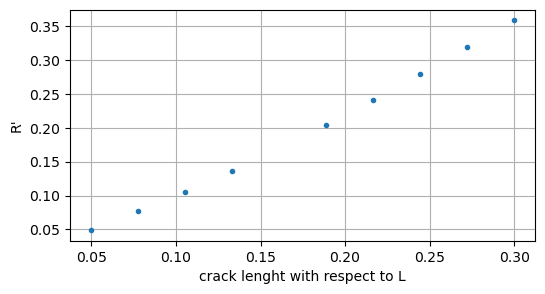

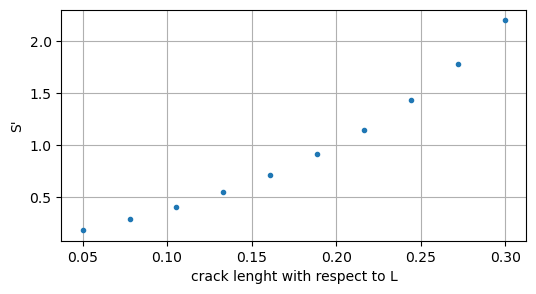

In [29]:
plt.figure()
plt.plot(Ls,R_prime,".")
plt.xlabel("crack lenght with respect to L")
plt.ylabel("R'")
plt.grid()

plt.figure()
plt.plot(Ls,S_prime,".")
plt.xlabel("crack lenght with respect to L")
plt.ylabel("S'")
plt.grid()

Both R' and S' are positives, so in this case, we have softening, so until the critical displacement, the crack propagates softly, then once the critical displacement is achieved, the structure fails in a brittle way

## Determine Kc using the experimental points and $K(a/l)$ obtained numerically. Verify that the value is in line with Ashby’s diagram


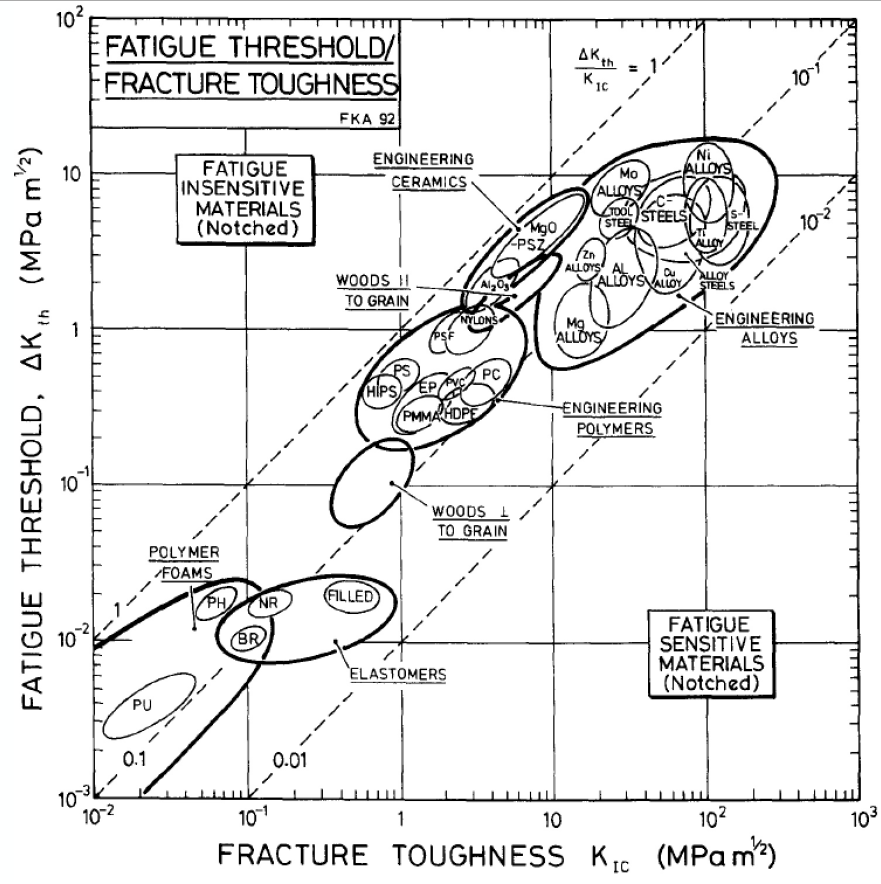

In [51]:
import pandas as pd

df = pd.read_csv('Default Dataset.csv', sep=';')

In [52]:
# Points of the curve 

a = df.iloc[:, 0].values
print(a)
deltaL_crit = df.iloc[:, 1].values
print(deltaL_crit)

[10.03491857 10.06410423 10.0609772  14.04781759 15.10045603 15.0990228
 15.05563518 15.09029316 19.11478827 20.12820847 20.13237785 20.13394137
 20.09602606 25.17172638 25.16938111 25.16899023 25.16612378 28.17563518]
[900.31530945 702.89250814 649.04495114 702.43648208 628.87035831
 604.19022801 557.05537459 453.86579805 455.67166124 406.76742671
 478.56416938 505.48794788 552.58631922 456.14592834 415.76026059
 409.02931596 359.66905537 383.45537459]


In [60]:
print(K)

[0.19161237 0.27019202 0.33834355 0.40291539 0.46660421 0.53038871]


In [61]:

Kc = []
for i in range(5,31,5):
    for pos,lcrack in enumerate(a):
        if abs(lcrack-i)<1:
            delta = deltaL_crit[pos]
            c = int(i/5) - 1
            k = K[c]
            Kc.append(3000*delta*1e-6*k/(0.1)**(0.5))


In [62]:
print(Kc)

print(np.mean(Kc))

[2.3077481284864794, 1.8017008632149158, 1.6636752208716048, 2.254686764284275, 2.0185535767100453, 1.9393350786222858, 1.7880412138338384, 1.456822408451389, 1.7417552516131911, 1.5548241462568873, 1.829259368443539, 1.932172576763533, 2.1122009669276425, 2.019173831165277, 1.8404027879229325, 1.8106076140492087, 1.592109672308565]
1.8625334982309183


The Mean value of Kc is 1.86 MPa $\sqrt m$ that is similar to the value obtained in the Ashby's diagram